In [1]:
import os

import numpy as np

from e3nn import o3
from e3nn.nn.models.gate_points_2102 import Convolution as ConvolutionGatePoints
from e3nn.nn.models.gate_points_2102 import Network as NetworkGatePoints
from e3nn.math import soft_one_hot_linspace

import plotly.express as px

import torch
from torch_geometric.loader import DataLoader

from minimal_basis.dataset.dataset_reaction import ReactionDataset
from minimal_basis.model.model_reaction import ReactionModel

from utils import (
    get_test_data_path,
    get_validation_data_path,
    get_train_data_path,
    read_inputs_yaml,
)

from ase import units as ase_units

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
inputs = read_inputs_yaml(os.path.join("input_files", "reaction_model.yaml"))

train_json_filename = inputs["debug_train_json"]
validate_json_filename = inputs["debug_validate_json"]

train_dataset = ReactionDataset( 
    root=get_train_data_path(),
    filename=train_json_filename,
    basis_filename=inputs["basis_file"],
)

validation_dataset = ReactionDataset(
    root=get_validation_data_path(),
    filename=validate_json_filename,
    basis_filename=inputs["basis_file"],
)

INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with data.
INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with basis information.
INFO:minimal_basis.dataset.dataset_reaction:Parsing basis information.
INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with data.
INFO:minimal_basis.dataset.dataset_reaction:Successfully loaded json file with basis information.
INFO:minimal_basis.dataset.dataset_reaction:Parsing basis information.


In [56]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=True)

In [4]:
all_mae_norms = []

for idx, data in enumerate(train_loader):

    interpolated_ts_coords = data.pos_interpolated_transition_state.detach().numpy()
    real_ts_coords = data.pos_transition_state.detach().numpy()
    difference_ts_coords = interpolated_ts_coords - real_ts_coords
    norm_difference_ts_coords = np.linalg.norm(difference_ts_coords, axis=1)

    # Mean absolute error
    mae = np.mean(norm_difference_ts_coords)
    all_mae_norms.append(mae)

    # Plot the real and interpolated TS structures
    # with two different colors on the same plot
    fig = px.scatter_3d(
        x=np.concatenate((real_ts_coords[:, 0], interpolated_ts_coords[:, 0])),
        y=np.concatenate((real_ts_coords[:, 1], interpolated_ts_coords[:, 1])),
        z=np.concatenate((real_ts_coords[:, 2], interpolated_ts_coords[:, 2])),
        color=np.concatenate((np.zeros(len(real_ts_coords)), np.ones(len(interpolated_ts_coords)))),
    )

    # Set the title of the plot as the mean absolute error
    fig.update_layout(title=f"MAE of structure prediction: {mae:.3f} Å")
    fig.write_html(f"plots/hamiltonian_model/interpolated_ts_{idx}_mae_{mae:.3f}.html")

# Plot a histogram of the MAE
fig = px.histogram(x=all_mae_norms, nbins=20, template="simple_white")
fig.update_layout(title="MAE structure prediction (Å)")
fig.update_xaxes(title_text="MAE (Å)")
fig.update_yaxes(title_text="Frequency")
fig.write_html("plots/hamiltonian_model/interpolated_ts_mae_histogram.html")
fig.show()

Dimensions of the edge length embedding: torch.Size([14, 1])
torch.Size([14, 1])


Text(0.5, 0, 'Distance')

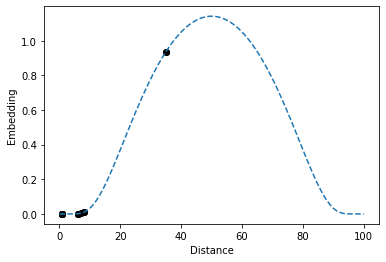

In [25]:
# Explore one-hot encoding for the species
num_basis = 1
max_species_embedding = 100
for idx, data in enumerate(train_loader):

    row, col = data.edge_index
    edge_vec = data.pos[row] - data.pos[col]
    species = data.species_initial_state
    species = species.squeeze()

    species_embedding = soft_one_hot_linspace(
        species,
        start=0.0,
        end=max_species_embedding,
        number=num_basis,
        basis='smooth_finite',
        cutoff=True,
    )
species_embedding = species_embedding.mul(num_basis**0.5)
print(f"Dimensions of the edge length embedding: {species_embedding.shape}")
plt.plot( species.detach().numpy(), species_embedding.detach().numpy(), 'o', color='k')
print(species_embedding.shape)

# Plot a smooth version of the plot above
plt.plot( torch.linspace(0, max_species_embedding, 100), soft_one_hot_linspace(
    torch.linspace(0, max_species_embedding, 100),
    start=0.0,
    end=max_species_embedding,
    number=num_basis,
    basis='smooth_finite',
    cutoff=True,
).mul(num_basis**0.5).detach().numpy(), ls='--')
plt.ylabel("Embedding")
plt.xlabel("Distance")

In [8]:
node_input_irrep = o3.Irreps("1x0e+1x1o")
node_attr_irrep = o3.Irreps("1x0e")
irreps_hidden = o3.Irreps("1x0e+1x1o")
irreps_out = o3.Irreps("1x0e+1x1o")
max_radius = 4
num_basis = 16
radial_layers = 1
radial_neurons = 8
num_neighbors = 4
typical_number_of_nodes = 12

network = ReactionModel(
    irreps_in=node_input_irrep,
    irreps_hidden=irreps_hidden,
    irreps_out=irreps_out,
    irreps_node_attr=node_attr_irrep,
    irreps_edge_attr=o3.Irreps(f"{num_basis}x0e"),
    radial_layers=radial_layers,
    max_radius=max_radius,
    num_basis=num_basis,
    radial_neurons=radial_neurons,
    num_neighbors=num_neighbors,
    typical_number_of_nodes=typical_number_of_nodes,
    reduce_output=False,
)

for idx, data in enumerate(train_loader):

    row, col = data.edge_index
    edge_vec = data.pos[row] - data.pos[col]

    norm_edge_vec = edge_vec.norm(dim=1)
    norm_edge_vec = norm_edge_vec.view(-1, 1)

    node_input = data.x
    node_attr = data.species_initial_state
    edge_src = data.edge_index[0]
    edge_dst = data.edge_index[1]
    edge_features = norm_edge_vec

    print(f"Shape of node_input: {node_input.shape}")
    print(f"Shape of node_attr: {node_attr.shape}")
    print(f"Shape of edge_src: {edge_src.shape}")
    print(f"Shape of edge_dst: {edge_dst.shape}")
    print(f"Shape of edge_features: {edge_features.shape}")

    output_network = network(data)

    output_to_plot = output_network.detach().numpy()
    # output_to_plot = network.output_network_initial_state.detach().numpy()
    # output_to_plot = network.output_network_final_state.detach().numpy()

    print(f"Shape of output_network: {output_network.shape}")
    fig = px.imshow(output_to_plot, template="simple_white")
    tickvals = node_attr.view(-1).detach().numpy().flatten()
    fig.update_yaxes(tickvals=np.arange(len(tickvals)), ticktext=tickvals)
    fig.show()

    break

Shape of node_input: torch.Size([13, 4])
Shape of node_attr: torch.Size([13, 1])
Shape of edge_src: torch.Size([11])
Shape of edge_dst: torch.Size([11])
Shape of edge_features: torch.Size([11, 1])
Shape of output_network: torch.Size([13, 4])


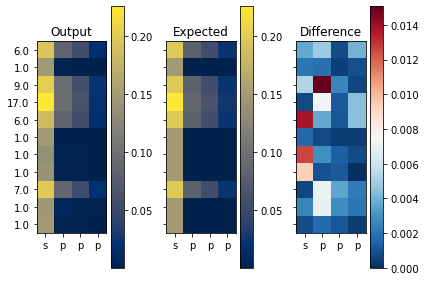

In [134]:
# Read in the model
model = torch.load("output/reaction_model.pt")

for idx, data in enumerate(train_loader):
    output = model(data)
    output = output.detach().numpy()
    output = np.abs(output)
    expected = data.x_transition_state.detach().numpy()
    difference = output - expected
    difference = np.abs(difference)
    fig, axs = plt.subplots(1, 3, figsize=(6, 5), sharex=True, sharey=True)
    cax = axs[0].imshow(output, cmap="cividis")
    fig.colorbar(cax, ax=axs[0])
    axs[0].set_title("Output")
    cax = axs[1].imshow(expected, cmap="cividis")
    fig.colorbar(cax, ax=axs[1])
    cax.set_clim(axs[0].get_images()[0].get_clim())
    axs[1].set_title("Expected")
    cax = axs[2].imshow(difference, cmap="RdBu_r", vmin=0)
    fig.colorbar(cax, ax=axs[2])
    axs[2].set_title("Difference")
    # Change the tick labels to the species
    tickvals = data.species_initial_state.view(-1).detach().numpy().flatten()
    axs[0].set_yticks(np.arange(len(tickvals)))
    axs[0].set_yticklabels(tickvals)
    axs[1].set_yticks(np.arange(len(tickvals)))
    axs[1].set_yticklabels(tickvals)
    axs[2].set_yticks(np.arange(len(tickvals)))
    axs[2].set_yticklabels(tickvals)
    # Set the x-axis ticks to be s, p, p, p
    axs[0].set_xticks(np.arange(4))
    axs[0].set_xticklabels(["s", "p", "p", "p"])
    axs[1].set_xticks(np.arange(4))
    axs[1].set_xticklabels(["s", "p", "p", "p"])
    axs[2].set_xticks(np.arange(4))
    axs[2].set_xticklabels(["s", "p", "p", "p"])
    fig.tight_layout()
    plt.show()

    break